The Helmholtz equation in 2D is a partial differential equation (PDE) that describes phenomena such as wave propagation, vibrations, and acoustics in a two-dimensional space. It is given by:

$$
\nabla^2 u(x, y) + k^2 u(x, y) = 0
$$

where  $\nabla^2$  is the Laplacian operator, $u(x, y)$ is the function representing the wave or field, and k is the wave number, which relates to the frequency of the wave.

The equation arises in scenarios where time-harmonic solutions (i.e., solutions that oscillate sinusoidally in time) are sought for wave equations. It’s particularly important in fields like acoustics, optics, and quantum mechanics, where it is used to model the steady-state behavior of waves in a confined region or space.

In 2D, the Helmholtz equation can be solved using separation of variables but, in this repository, we are going to solve it using neural networks with fully-conected layers.

For this problem, the boundary condition that we consider is $u(x, y) = 0$ for $(x, y)$ being in the boundary.

In [1]:
import torch
import random

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm

In [2]:
# Check if GPU is available, if is then the train process are going to be runned in it.

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print("The process are gonna be runned in " + device)

The process are gonna be runned in cpu


In [3]:
# Here we define some parameters and some important functions to define our model, such as the analitical solution to compare
# and the creation of boundary domain and generates domain data

k = 2*np.pi

def solution(x, y):
    return np.sin(k*x)*np.sin(k*y)

def random_point(bound=int):
    if bound == 0:
        return [np.round(random.random(), 3), 0]
    elif bound == 1:
        return [1, np.round(random.random(), 3)]
    elif bound == 2:
        return [np.round(random.random(), 3), 1]
    else:
        return [0, np.round(random.random(), 3)]

def gen_traindata(num=int, bound=int):
    points      = []
    for i in range(num):
        points.append(random_point(bound))

    points      = np.reshape(points, (len(points), 2))
    values      = np.zeros(len(points))
    
    return [points, values]

In [4]:
# Define the model thats gonna be trained

class FNC(nn.Module):
    # Defines the Neural Network that we're going to use for train our solution
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        self.input        = nn.Linear(n_input, n_hidden)          # Define the input later for our NN
        self.hidden       = nn.Linear(n_hidden, n_hidden)     # Defines hidden layers for our NN 
        self.output       = nn.Linear(n_hidden, n_output)         # Define the output layer the NN

    def forward(self, x, y):
        n_layers    = 4
        inputs      = torch.cat([x, y], axis = 1)

        inputs  = self.input(inputs)
        inputs  = torch.sin(inputs)
        
        for i in range(n_layers):
            inputs = self.hidden(inputs)
            inputs = torch.sin(inputs)

        outputs = self.output(inputs)
        outputs = torch.sin(outputs)
        
        return outputs

In [5]:
#  The first step is create the neural network, that is, define the number of layers and the number of neurons
#  for each layer

n_input     = 2
n_output    = 1
n_hidden    = 50
N           = 10001       # Number of iterations for training
N_bound     = 50          # Number of data to compute boundary conditions
N_domain    = 50          # Number of elements to construct the domain for PINN

# Define a set of weights for the loss function

c1          = 1e0
c2          = 1e0

# Create the network with the number of layers and neurons defined above

PINN        = FNC(n_input, n_output, n_hidden)
PINN        = PINN.to(device)

# Define the optimizer to be used in the training stage

optimizer   = torch.optim.Adam(PINN.parameters(), lr=1e-3)
loss_values = []

In [6]:
# We define our domain

x_domain    = torch.linspace(0, 1, N_domain, device=device)
y_domain    = torch.linspace(0, 1, N_domain, device=device)
x_domain, y_domain = torch.meshgrid(x_domain, y_domain, indexing='ij')

x_domain    = x_domain.reshape(-1, 1).requires_grad_(True)
y_domain    = y_domain.reshape(-1, 1).requires_grad_(True)

for train in tqdm(range(N), desc="Training our model"):
    optimizer.zero_grad()

    # Compute all the derivatives functions for implement the EDP
    u = PINN(x_domain, y_domain)

    dudx    = torch.autograd.grad(u, x_domain, torch.ones_like(u), create_graph=True)[0]
    dudy    = torch.autograd.grad(u, y_domain, torch.ones_like(u), create_graph=True)[0]
    dudx2   = torch.autograd.grad(dudx, x_domain, torch.ones_like(dudx), create_graph=True)[0]
    dudy2   = torch.autograd.grad(dudy, y_domain, torch.ones_like(dudy), create_graph=True)[0]

    # We insert the EDP to solve and, with that, we construct the loss function related
    f         = k**2*torch.sin(k*x_domain)*torch.sin(k*y_domain)
    loss_edp  = torch.mean((dudx2 + dudy2 + k**2*u + f)**2)

    # We define the loss function associated with the boundary condition
    loss_predict = []
    for bound in range(4):
        points, values = gen_traindata(N_bound, bound)

        points  = torch.from_numpy(points)
        points  = points.to(device)
        x_data  = points[:, 0:1].to(torch.float32)
        y_data  = points[:, 1:2].to(torch.float32)

        u_predict   = PINN(x_data, y_data)
        loss_bound  = torch.sum((u_predict)**2)
        loss_predict.append(loss_bound)

    loss_predict = loss_predict[0] + loss_predict[1] + loss_predict[2] + loss_predict[3]
    loss    = c1*loss_edp + c2*loss_predict

    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())

Training our model: 100%|██████████| 10001/10001 [04:47<00:00, 34.80it/s]


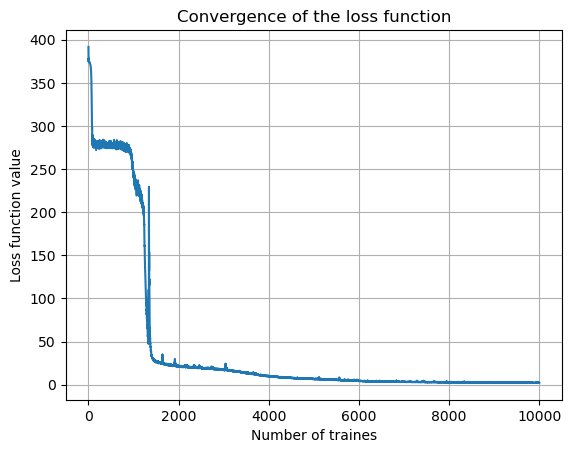

In [7]:
# To analyze the results of our model is important to see how is the convergence of the loss function, this give us information about 
# how the model "learns" the solution

plt.plot(range(N), loss_values)
plt.grid()
plt.xlabel('Number of traines')
plt.ylabel('Loss function value')
plt.title('Convergence of the loss function')

plt.show()

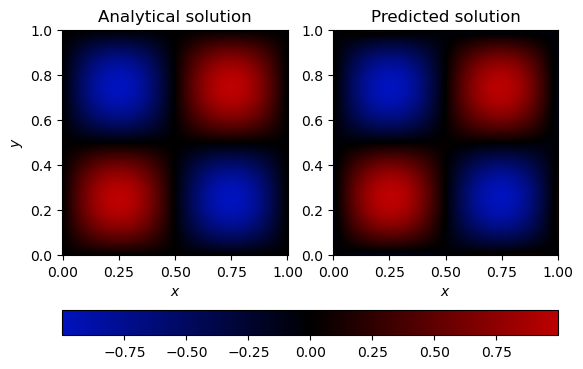

In [8]:
# Now, compare the model with the analytical solution

cm = LinearSegmentedColormap.from_list('cm', (
    # Edit this gradient at https://eltos.github.io/gradient/#cm=0012BD-000000-BD0000
    (0.000, (0.000, 0.071, 0.741)),
    (0.500, (0.000, 0.000, 0.000)),
    (1.000, (0.741, 0.000, 0.000))))

N_plot  = 300
x       = np.linspace(0, 1, N_plot)
y       = x
X, Y    = np.meshgrid(x, y)
Z       = solution(X, Y)

xargs   = np.array([[x[i], y[j]] for i in range(N_plot)  for j in range(N_plot)])
xargs   = np.reshape(xargs, (-1, 2))

x       = torch.from_numpy(xargs[:, 0:1]).to(torch.float32).to(device)
y       = torch.from_numpy(xargs[:, 1:2]).to(torch.float32).to(device)

prediction  = PINN(x, y)
prediction  = prediction.to('cpu')
Z_pred = prediction.detach().numpy()
Z_pred = np.reshape(Z_pred, (N_plot, N_plot))

fig, axs=plt.subplots(1, 2)
figures = []

ax = axs[0]
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Analytical solution')
ax.set_aspect('equal')
figures.append(ax.pcolor(X, Y, Z, cmap=cm))

ax = axs[1]
ax.set_xlabel('$x$')
ax.set_title('Predicted solution')
ax.set_aspect('equal')
figures.append(ax.pcolor(X, Y, Z_pred, cmap=cm))

fig.colorbar(figures[0], ax=axs, orientation='horizontal')
plt.show()